# Building A Handwritten Digits Classifier

![](https://miro.medium.com/max/1099/1*qgxFpzSmPMi_A2KY0LIsjg.png)

In this project, our goals are the following:

* to explore why image classification is difficult

* to observe the limitations of traditional machine learning models for image classification

* to train, test, and improve a few different deep neural networks for image classification

### Why is image classification difficult?

The first reason is that each image in a training set is high-dimensional. Essentially, each pixel in an image is a feature, and a column. A photo with a resolution of 128x128 thus has 16,384 features. Going through a training set of thousands of images would obviously generate an insanely high computational cost.

Secondly, most images are often downsampled to lower resolutions and transformed to grayscale to save on processing time. The problem with this is that it leads to a significant loss of detail that is available for our model's training.

Lastly, the features in an image don't have linear or nonlinear relationships with one another that can be easily picked up by linear or logisitc regression models. The world is big, colorful, and analog - but we have to condense, desaturate, and digitize it. This eventually leads to each pixel in an image having a numeric value where we can perform lots of calculations on it and hopefully get some meaningful data out of it.

### Working with image data

We'll be using the Scikit-learn library for this project, as it comes pre-loaded with a number of [datasets](https://scikit-learn.org/stable/datasets.html). The [load_digits()](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) function returns a copy of the [hand-written digits dataset](http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits) from UCI that we will be using for this project.

Since a dataframe is a tabular representation of data, each image we will be looking at is represented as a row of pixel values. We will essentially have to examine each row and reconstruct it to form the original 8x8 pixel image. We'll then plot the image onto a coordinate grid.

## Importing Libraries and Exploring Data

We'll be importing the load_digits function from the scikit-learn dataset library. We'll have to take the resulting data from the load_digits function and convert it to a 2D-array.

In [1]:
from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier

#we include the following to silence the warnings
import warnings
from sklearn.exceptions import ConvergenceWarning

digits = load_digits()
labels = pd.Series(digits['target'])
data = pd.DataFrame(digits['data'])

In [2]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [3]:
def show_digit(images):
    #SET UP FIGURE
    fig = plt.figure(figsize=(16,10))
    fig.suptitle('Handwritten Digits', fontsize=28)
    dim = len(data.iloc[0])
    
    #LOOP THROUGH IMAGES TO DISPLAY
    for i, image in enumerate(images):
        #CREATE AX OBJECT AND CONFIGURE
        ax = fig.tight_layout(pad=1)
        ax = fig.add_subplot(2,4,i+1)
        ax.set_title(f'Digit - row[{image}]', fontsize=20)
        xy = np.arange(0, dim, 1)
        ax.set_xticks(xy, fontsize=14)
        ax.set_yticks(xy, fontsize=14)

        #ACTUAL PLOT
        ax.imshow(data.iloc[image].values.reshape(8,8), cmap='gray_r')
    
    plt.show()

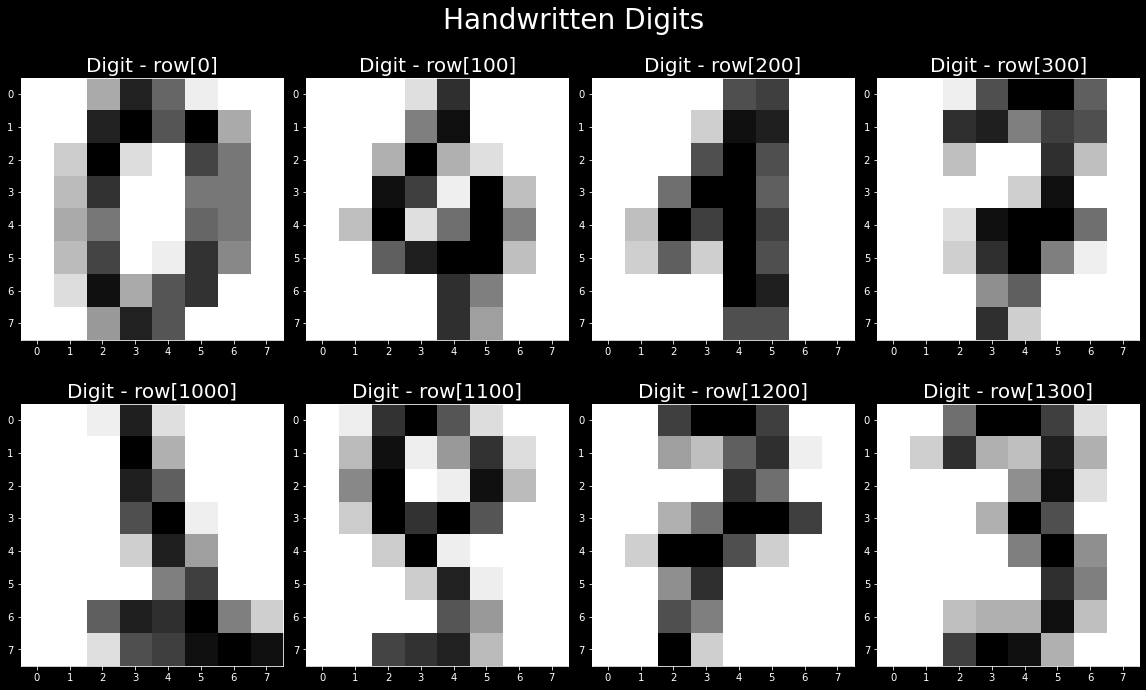

In [4]:
images = [0, 100, 200, 300, 1000, 1100, 1200, 1300]
show_digit(images)

### Training & Testing Functions - KNeighborsClassifier

Before we create any models, we'll have to decide on how we're going to approach this problem. While linear and logistic regression models make assumptions about the linearity between the features and the output labels, the k-nearest neighbors algorithm makes no such assumption. Due to this fact, we'll begin by implementing a k-nearing neighbors algorithm. This algorithm compares every unseen observation in the test set to all training observations to look for similar observations. It will then find the label with the most nearby observations and assign that as the prediction for the unseen observation.

Some **advantages** of using the K-Nearest Neighbors Algorithm:

* Intuitive and simple
* Has no assumptions about the data
* No training period
* Can be used for both Classification and Regression problems
* Variety of distance criteria to choose from (Euclidean, Manhattan, etc.)

Below we'll create functions to help with our pipeline for testing and training our k-nn algorithm. We'll be using the [KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) to help. We'll also implement a function that performs cross-validation using the [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html?highlight=kfold#sklearn.model_selection.KFold) model.

In [5]:
#values we re-use numerous times
k_values = np.arange(1,21,1) #used in knn models
n_splits = np.arange(4,13,2) #used in k-fold cross validation
neurons = [pow(2, x) for x in np.arange(2,9,1)] #used in nn models

#lists to hold resulting accuracy lists
model_results = []
model_names = []

#train a knn model
def train_knn(k, train_features, train_labels):
    knn = KNeighborsClassifier(k)
    knn.fit(train_features, train_labels)
    return knn

#test the accuracy of given model
def test(model, test_features, test_labels):
    predictions = model.predict(test_features)
    return accuracy_score(test_labels, predictions)

#cross validates using KFold
def cross_validate(k, n_splits=4):
    train_acc = []
    test_acc = []
    kf = KFold(n_splits, shuffle=True, random_state=1)
    for train_index, test_index in kf.split(data):
        #splitting the data
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        
        #train model
        model = train_knn(k, train_features, train_labels)
        
        #calculate accuracies
        train_accuracy = test(model, train_features, train_labels)
        test_accuracy = test(model, test_features, test_labels)
        
        #append accuracies to list
        train_acc.append(train_accuracy)
        test_acc.append(test_accuracy)
        
    return np.mean(train_acc), np.mean(test_acc)

### Testing K-Nearest Neighbors Algorithm

In [6]:
#function to help resuse code
def plot_knn_model(title, n_splits=4):
    #lists to contain accuracies of respective training/test sets
    fold_train_acc = {}
    fold_test_acc = {}
    train_acc = []
    test_acc = []
    
    #figure details
    fig, ax = plt.subplots(figsize=(12,8))
    fig.tight_layout(pad=3)
    fig.suptitle(y=0.9, t=f'Mean Accuracy vs. {title}', va='bottom', fontsize=22)
    
    if type(n_splits) != int:
        #loop to calculate accuracies with various k & n values
        for k in k_values:
            fold_train_acc[k] = []
            fold_test_acc[k] = []
            for n in n_splits:
                training, testing = cross_validate(k, n)        
                fold_train_acc[k].append(training)
                fold_test_acc[k].append(testing)        
            ax.plot(n_splits, fold_test_acc[k])
    else:
        #loop to calculate accuracies with various k values
        for k in k_values:
            training, testing = cross_validate(k)
            train_acc.append(training)
            test_acc.append(testing)

    #plot details
    if type(n_splits) != int:
        ax.set_xticks(n_splits, fontsize=14)
        ax.set_xlabel('Number of Folds', fontsize=14)
        ax.legend(k_values, frameon=False, bbox_to_anchor=(1.02, 1), fontsize=14, title='k-neighbors')
    else:
        ax.plot(k_values, train_acc, linewidth=3, label='training')
        ax.plot(k_values, test_acc, linewidth=3, label='test')
        ax.set_xlabel('k-Neighbors', fontsize=14)
        ax.set_xticks(k_values, fontsize=14)
        ax.legend(fontsize=14)        
    
    ax.set_ylabel('Accuracy', fontsize=14)    
    plt.show()
    
    if type(n_splits) != int:
        return fold_test_acc
    else:
        return test_acc

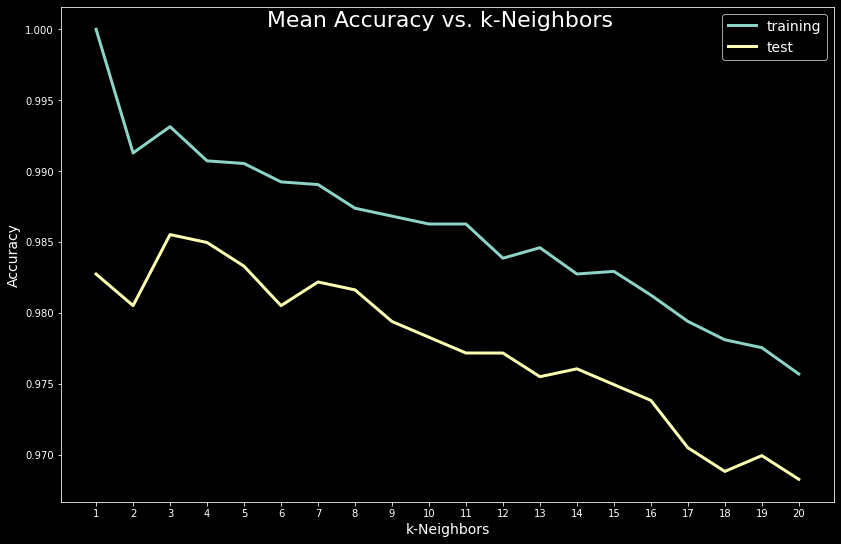

In [7]:
title = 'k-Neighbors'
KNN_results = plot_knn_model(title)

### Testing K-Nearest Neighbors + Varying Folds In Cross-Validation

From the above plot we can see that we achieved our highest testing accuracy using 3 neighbors in our KNeighborsClassifier model. The more neighbors we tested, the more the accuracy declined. The test was performed with 4 folds (our chosen default). For reference, the number of folds is the number of groups that a given data sample is to be split into. Let's redo the same test, but this time we'll also vary the number of folds in the cross_validation test.

Some **advantages** of using K-Fold Cross Validation:

* Checks model generalization & performance
* Can help reduce overfitting the training data
* Useful in hyperparameter tuning

Some **disadvantages** of using K-Fold cross Validation:

* Can increase training time significantly
* Very computationally expensive

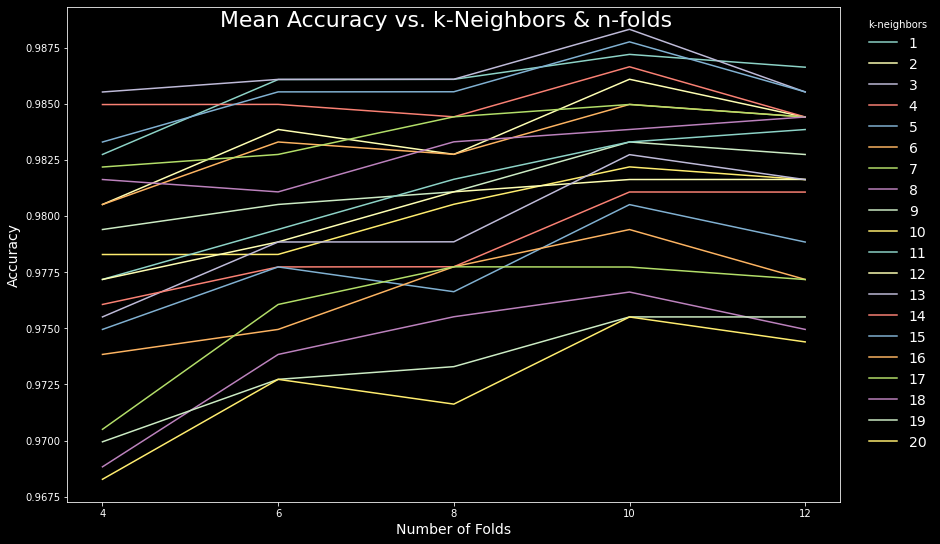

In [8]:
title = 'k-Neighbors & n-folds'
knn_test_acc = plot_knn_model(title, n_splits)

In [9]:
#function to display accuracies between 4 and 10 folds
def get_acc(acc, metric, label):
    #create new dataframe for the metric you want to look at
    results = pd.DataFrame()
    results[label] = metric
    
    #loop through each value in the metric and pull out values of interest
    for idx, i in enumerate(metric):
        results.loc[idx, '4-fold Acc.'] = acc[i][0]  #0 is 4-folds
        results.loc[idx, '10-fold Acc.'] = acc[i][3] #3 is 10-folds
        
    #change indexes, and sort biggest -> smallest
    results.set_index(label, inplace=True)
    results.sort_values('10-fold Acc.', ascending=False, inplace=True)
    return results

In [10]:
KNN_results = get_acc(knn_test_acc, k_values, 'k-neighbors')
model_results.append(KNN_results)
model_names.append('K-NN')
KNN_results.head(5)

,4-fold Acc.,10-fold Acc.
k-neighbors,,
3,0.985528,0.988321
5,0.983300,0.987762
1,0.982746,0.987204
4,0.984969,0.986651
2,0.980518,0.986096


We can easily see from the above graph and table that while we got good results by using 4 folds, we were able to increase the accuracy for literally every value in our k_values list by increasing the number of folds. We can also see that after 10 folds, the accuracy universally drops off for all of our k_values. There is no law that states that k=10 is the best number, but research has shown that it tends to produce the most fair results.

> *The choice of k is usually 5 or 10, but there is no formal rule. As k gets larger, the difference in size between the training set and the resampling subsets gets smaller. As this difference decreases, the bias of the technique becomes smaller.* 
>
> — Page 70 [Applied Predictive Modeling](https://amzn.to/2Fmrbib), 2013

>*To summarize, there is a bias-variance trade-off associated with the choice of k in k-fold cross-validation. Typically, given these considerations, one performs k-fold cross-validation using k = 5 or k = 10, as these values have been shown empirically to yield test error rate estimates that suffer neither from excessively high bias nor from very high variance.*
>
> — Page 184, [An Introduction to Statistical Learning](https://amzn.to/2FkHqvW), 2013.

### Training & Testing Functions - Neural Networks w/ Single Hidden Layer

Some **disadvantages** of using a k-nearest neighbors approach are:

* High memory usage (for each observation, the algorithm needs to compare it to every other observation)
* Doesn't work well with large datasets
* Doesn't work well with high-dimensions
* sensitive to noisy data, missing values, and outliers
* Difficult to pick "correct" value of k

Let's now try to calculate the accuracies using a neural network with a single hidden layer. To do this, we will be using the [MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) package from scikit-learn.

There are many kinds of neural networks, far too many to describe in this project. However, these are some general **advantages** to using a neural network:

* **Data** - neural networks give better results when they gather more information. Traditional machine learning algorithms will reach a level where more data doesn't improve the performance.
* **Ability** - to work with incomplete data - the performance loss depends on the significance of the missing data.
* **Dynamic** - good to model with nonlinear data with a larger number of imputs, such as images. It splits up classification into a layered network of simpler elements.
* **Parallel processing ability** - neural networks have numerical strength, allowing them to perform multiple jobs simultaneously

In [11]:
#train a nn model
def train_nn(train_features, train_labels, neurons, layers, activator):
    layer = (neurons,) * layers
    mlp = MLPClassifier(hidden_layer_sizes=layer, activation=activator, max_iter=1000)
    mlp.fit(train_features, train_labels)
    return mlp

#cross validates using KFold
def cross_validate_nn(neurons, n_splits=4, layers=1, activator='logistic'):
    train_acc = []
    test_acc = []
    kf = KFold(n_splits, shuffle=True, random_state=1)
    for train_index, test_index in kf.split(data):
        #splitting the data
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        
        #hide warnings, then train model
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=ConvergenceWarning) 
            model = train_nn(train_features, train_labels, neurons, layers, activator)
        
        #calculate accuracies
        train_accuracy = test(model, train_features, train_labels)
        test_accuracy = test(model, test_features, test_labels)
        
        #append accuracies to list
        train_acc.append(train_accuracy)
        test_acc.append(test_accuracy)
    return np.mean(train_acc), np.mean(test_acc)

In [12]:
#function to help resuse code
def plot_nn_model(title, n_splits=4, layers=1):
    #lists to contain accuracies of respective training/test sets
    fold_train_acc = {}
    fold_test_acc = {}
    train_acc = []
    test_acc = []
    
    #figure details
    fig, ax = plt.subplots(figsize=(12,8))
    fig.tight_layout(pad=6, )
    fig.suptitle(y=0.9, t=f'Mean Accuracy vs. {title}', fontsize=22, va='bottom')
    
    if type(n_splits) != int:
        #loop to calculate accuracies with various k & n values
        for i in neurons:
            fold_train_acc[i] = []
            fold_test_acc[i] = []
            for n in n_splits:
                training, testing = cross_validate_nn(i, n, layers)
                fold_train_acc[i].append(training)
                fold_test_acc[i].append(testing)        
            ax.plot(n_splits, fold_test_acc[i], linewidth=3)
    else:
        #loop to calculate accuracies with various k values
        for n in neurons:
            training, testing = cross_validate_nn(n)
            train_acc.append(training)
            test_acc.append(testing)

    #plot details
    if type(n_splits) != int:
        ax.set_xticks(n_splits, fontsize=14)
        ax.set_xlabel('Number of Folds', fontsize=14)
        ax.legend(neurons, frameon=False, bbox_to_anchor=(1.02, 1), fontsize=14, title='#-neurons')
    else:
        ax.plot(np.arange(len(neurons)), train_acc, linewidth=3, label='training')
        ax.plot(np.arange(len(neurons)), test_acc, linewidth=3, label='test')
        ax.set_xticks(np.arange(len(neurons)), fontsize=14)
        ax.set_xticklabels(neurons)
        ax.set_xlabel('Number of Neurons', fontsize=14)
        ax.legend(fontsize=14)
    
    ax.set_ylabel('Accuracy', fontsize=14)    
    plt.show()
    
    if type(n_splits) != int:
        return fold_test_acc
    else:
        return test_acc

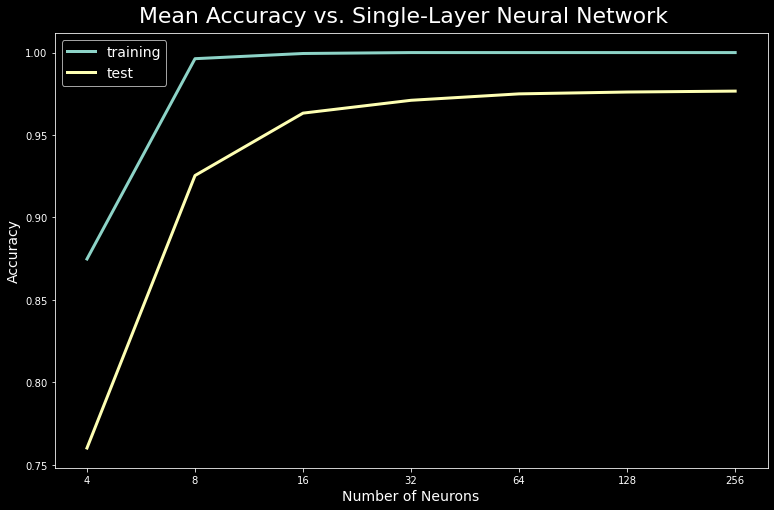

In [13]:
title = 'Single-Layer Neural Network'
NN_results = plot_nn_model(title)

We can see from the above that our model is overfitting as soon as we have 16 or more neurons in our single hidden layer. This is evidenced by our training model having 100% accuracy, while the test model does not. We can re-do the previous test and combine it with K-Fold Cross Validation to see if we can find any improvements in our neural network model. Note that combining these two methods is very computationally taxing, and can take a long time depending on the size of the data.

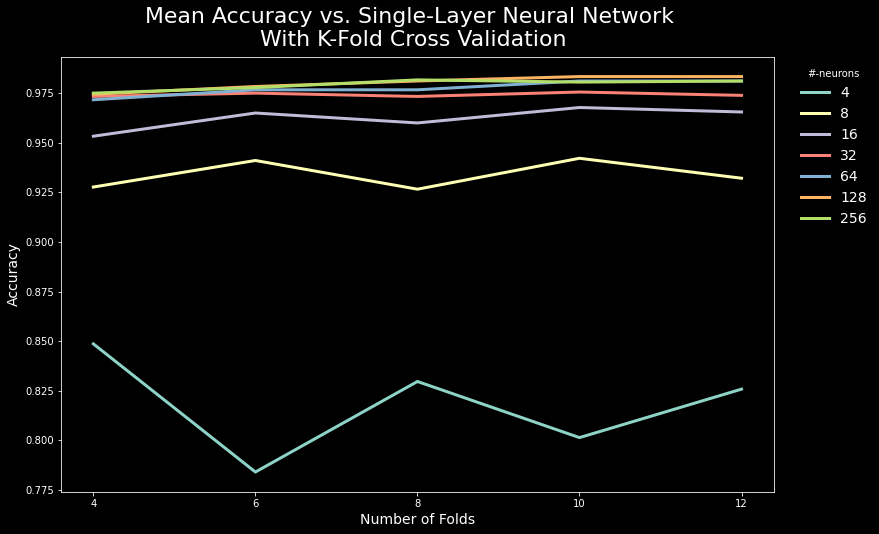

In [14]:
title = 'Single-Layer Neural Network\n With K-Fold Cross Validation'
NN_results = plot_nn_model(title, n_splits)

In [15]:
#show comparison
NN1L_results = get_acc(NN_results, neurons, 'Neurons')
model_results.append(NN1L_results)
model_names.append('NN-1L')
NN1L_results.head(5)

,4-fold Acc.,10-fold Acc.
Neurons,,
128,0.974399,0.983296
64,0.971616,0.981074
256,0.974955,0.980515
32,0.973290,0.975509
16,0.953252,0.967709


We can see that in general, the more neurons we have in our network, the higher the accuracy. The results of this test are slightly different each time we run it, but at **10 folds**, the accuracy reaches peak of **~0.982**. Similar to our previous test, we can see an overall improvement in accuracy when we increase the number of folds to 10. 

Neural networks are fantastic to use, but they are not perfect. Here are some **disadvantages** to using them:

* **Black box nature** - very difficult to understand "why" a neural network produces a specific output.
* **Amount of data** - while in general neural networks perform better with increasing amounts of data, they *need* a large amount of data. This can cause issues with overfitting and generalization.
* **Potential to be computationally expensive** - amount of processing time heavily depends on size and complexity of the data, and the hardware being used.
* **Determination of "proper" network structure** - relies heavily on trial and error.

### Observations So Far

* Our K-nearest neighbors algorithm achieved a peak of **~98.83%** accuracy, with 3 neighbors and 10 folds.
* Our neural network achieved a peak of **~98.2%** accuracy, with 256 neurons and 10 folds.
* Our neural network wasn't as good, but we only used a single hidden layer. Tweaking our neural network to have multiple hidden layers may improve performance further.

### Training & Testing Functions - Neural Networks w/ Two Hidden Layers

We're now going to alter our neural network functions by having it use two hidden layers instead of one.

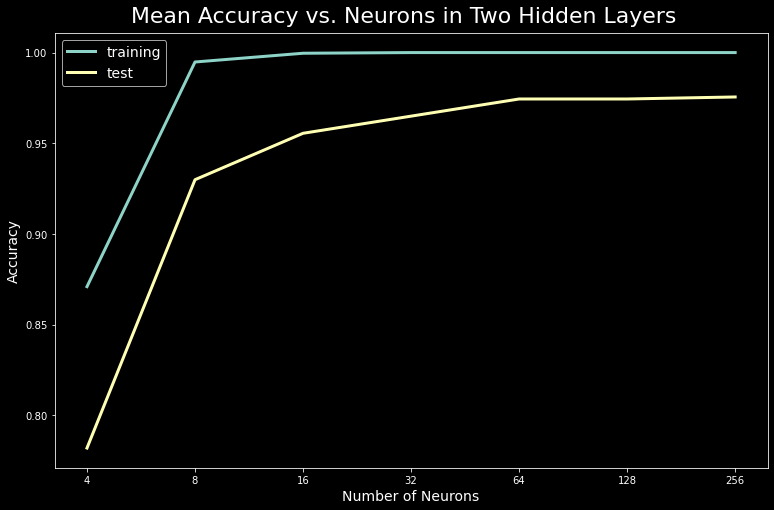

In [16]:
title = 'Neurons in Two Hidden Layers'
NN2L_results_nofold = plot_nn_model(title, layers=2)

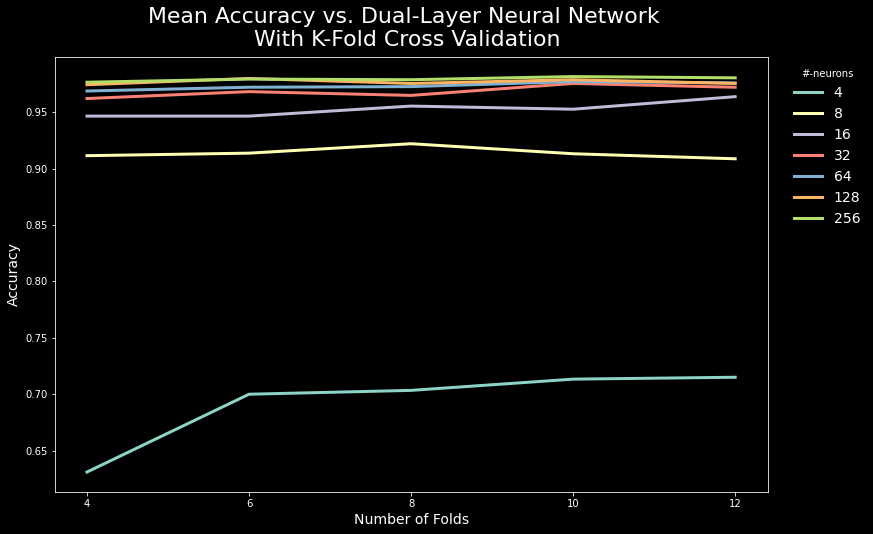

In [17]:
title = 'Dual-Layer Neural Network\n With K-Fold Cross Validation'
NN2_results = plot_nn_model(title, n_splits, layers=2)

In [18]:
#show comparison
NN2L_results = get_acc(NN2_results, neurons, 'Neurons-2L')
model_results.append(NN2L_results)
model_names.append('NN-2L')
NN2L_results.head(5)

,4-fold Acc.,10-fold Acc.
Neurons-2L,,
256,0.976625,0.981629
128,0.974401,0.978852
64,0.968834,0.977182
32,0.962157,0.975515
16,0.946575,0.952694


As we can see, the neural network with two hidden layers performs very similarly to the single-layer network. As we increase the number of neurons, the accuracy goes up. Similar to the previous test, we see a general improvement in accuracy with 10 folds. However, the advantage of one over the other is incredibly minute (~0.006 difference), and difficult to visualize.

### Three Hidden Layers

Using more hidden layers in a neural network is known to increase the amount of overfitting that happens. To aid with this, we would normally increase the number of folds we use for k-fold cross validation to a larger number, but in the interest of consistency, we will test using the same number of folds as the other tests.

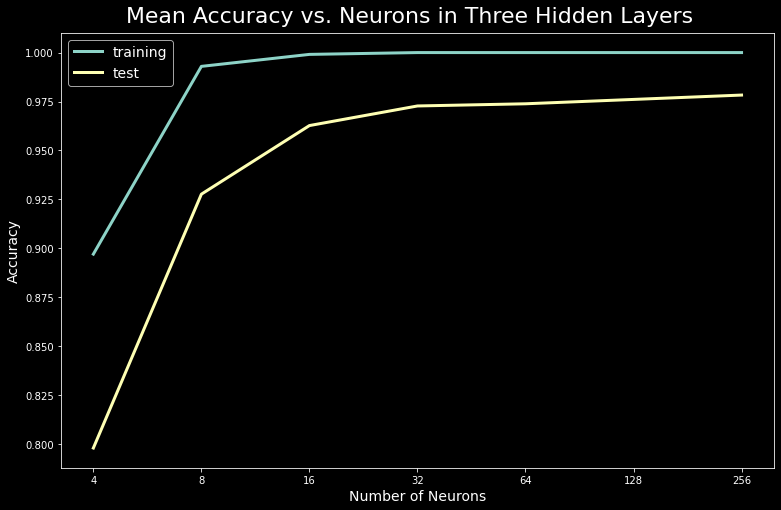

In [19]:
title = 'Neurons in Three Hidden Layers'
NN3L_results_nofold = plot_nn_model(title, layers=3)

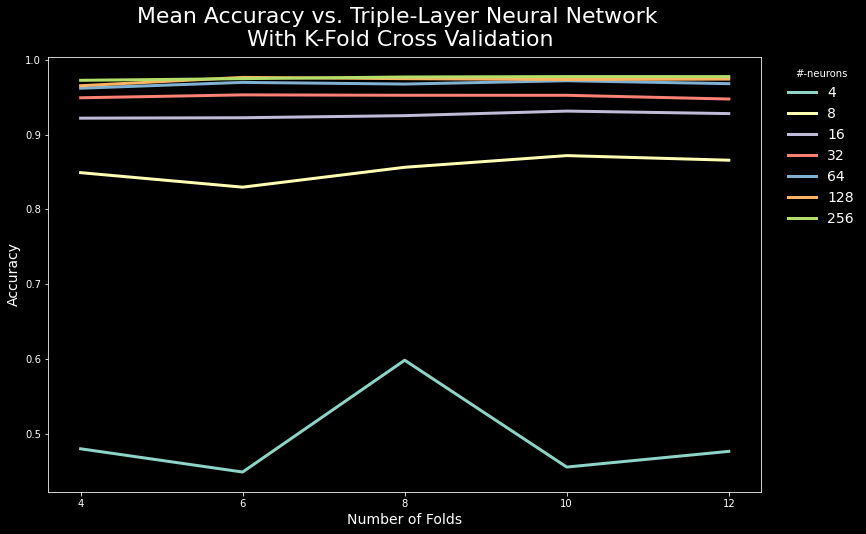

In [20]:
title = 'Triple-Layer Neural Network\n With K-Fold Cross Validation'
NN3_results = plot_nn_model(title, n_splits, layers=3)

In [21]:
#show comparison
NN3L_results = get_acc(NN3_results, neurons, 'Neurons-3L')
model_results.append(NN3L_results)
model_names.append('NN-3L')
NN3L_results.head(5)

,4-fold Acc.,10-fold Acc.
Neurons-3L,,
256,0.972731,0.977741
128,0.965494,0.973842
64,0.962162,0.972185
32,0.949355,0.952691
16,0.922084,0.931555


### Observations & Comparisons Thus Far

As with our other neural networks, the more neurons we have, the better the accuracy. We can see that with three hidden layers and 10 folds, our neural network was able to achieve an accuracy of **~97.77%**, which is slightly worse than the other two neural network configurations. The k-nn algorithm is still out-performing the other models thus far.

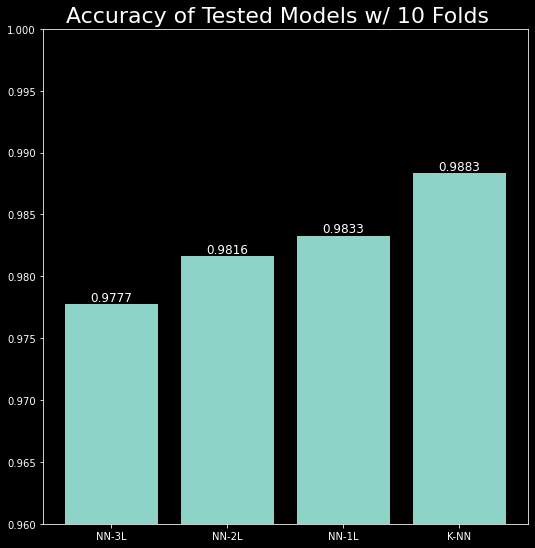

In [22]:
def comp_acc(model_results, model_names):
    acc_comp = {}

    for i, model in enumerate(model_results):
        row = model['10-fold Acc.'].idxmax()
        acc_comp[model_names[i]] = model.loc[row, '10-fold Acc.'] #1 is the 10 folds column

    #sorts dictionary by accuracy score
    acc_list = sorted(acc_comp.items(), key=lambda x:x[1])
    acc_sorted = dict(acc_list)

    #figure details
    fig, ax = plt.subplots(figsize=(8,8))
    fig.tight_layout(pad=3)
    fig.suptitle('Accuracy of Tested Models w/ 10 Folds', fontsize=22)

    #plot details
    bars = ax.bar(acc_sorted.keys(), acc_sorted.values())

    # Text on the top of each bar
    for i, k in enumerate(acc_sorted.keys()):
        height = bars[i].get_height()
        plt.text(x = i, y = height, s = f'{round(acc_sorted[k],4)}', size = 12, ha='center', va='bottom')
    
    #get lowest and highest values so we can set an appropriate limit
    lowest = list(acc_sorted.keys())[0]
    highest = list(acc_sorted.keys())[len(acc_sorted)-1]
    low_lim = round(acc_sorted[lowest],2) - 0.02
    high_lim = round(acc_sorted[highest],2) + 0.01
    
    ax.set_ylim(low_lim, high_lim)
    plt.show()
    
comp_acc(model_results, model_names)

## Exploring Other Models - Decision Tree Classifier

We've been experimenting a lot with neural networks and k-nearest neighbor models. Let's modify our existing pipeline to measure the accuracies of a [Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) model and a [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html?highlight=random%20forest#sklearn.ensemble.RandomForestClassifier) model.

We will begin by using the pure default values for the decision tree model. The means that the nodes of the tree will be expanded until all leaves contain less than the `min_samples_split` value (which by default is 2).

Some **advantages** of using Decision Trees:
* Requires less effort for data preparation.
* Does not require scaling of data.
* Can automatically handle missing values.
* Can handle both continuous and categorical variables.
* Relatively intuitive and easy to explain to others.

Soem **disadvantages** of using Decision Trees:
* Noise in data can cause instability in the tree's structure.
* Sometimes calculations can become much more complex compared to other algorithms.
* Tendency to overfit the data.
* Not suitable for large datasets.


In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#powers of 2 - used to test various min_sample_leaf and max_depth values
values = [pow(2,x) for x in np.arange(0,6,1)]

#train a decision tree model
def train_dt(train_features, train_labels, depth, leaves):
    dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=leaves)
    dt.fit(train_features, train_labels)
    return dt

#train a random forest model
def train_rf(train_features, train_labels, depth, leaves):
    rf = RandomForestClassifier(max_depth=depth, min_samples_leaf=leaves)
    rf.fit(train_features, train_labels)
    return rf

#cross validates using KFold
def cross_validate_tree(model, n_splits=4, depth=8, leaves=2):
    train_acc = []
    test_acc = []
    kf = KFold(n_splits, shuffle=True, random_state=1)
    for train_index, test_index in kf.split(data):
        #splitting the data
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        
        #trains the model
        if model == 'dt':
            model = train_dt(train_features, train_labels, depth, leaves)
        elif model == 'rf':
            model = train_rf(train_features, train_labels, depth, leaves)
        
        #calculate accuracies
        train_accuracy = test(model, train_features, train_labels)
        test_accuracy = test(model, test_features, test_labels)
        
        #append accuracies to list
        train_acc.append(train_accuracy)
        test_acc.append(test_accuracy)
    return np.mean(train_acc), np.mean(test_acc)

In [24]:
#function to help reuse code
def plot_tree_model(model, title, legend, arg=''):
    train_acc = {}
    test_acc = {}
    
    #figure details
    fig, ax = plt.subplots(figsize=(12,8))
    fig.tight_layout(pad=6)
    fig.suptitle(f'Mean Accuracy vs. {title}', fontsize=22)

    for i in values:
        train_acc[i] = []
        test_acc[i] = []
        for j in n_splits:
            if arg == 'depth':
                training, testing = cross_validate_tree(model, n_splits=j, depth=i) #depths vary, leaves are constant
            else:
                training, testing = cross_validate_tree(model, n_splits=j, leaves=i) #leaves vary, depth is constant
            train_acc[i].append(training)
            test_acc[i].append(testing)
        ax.plot(n_splits, test_acc[i], linewidth=3)
    
    #plot details
    if arg == '':
        arg = 'leaves'
    ltitle = arg.capitalize()
    ax.set_xticks(n_splits, fontsize=14)
    ax.set_xlabel('Number of Folds', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.legend(values, frameon=False, bbox_to_anchor=(1.02, 1), fontsize=14, title=ltitle)
    plt.show()
    
    return test_acc

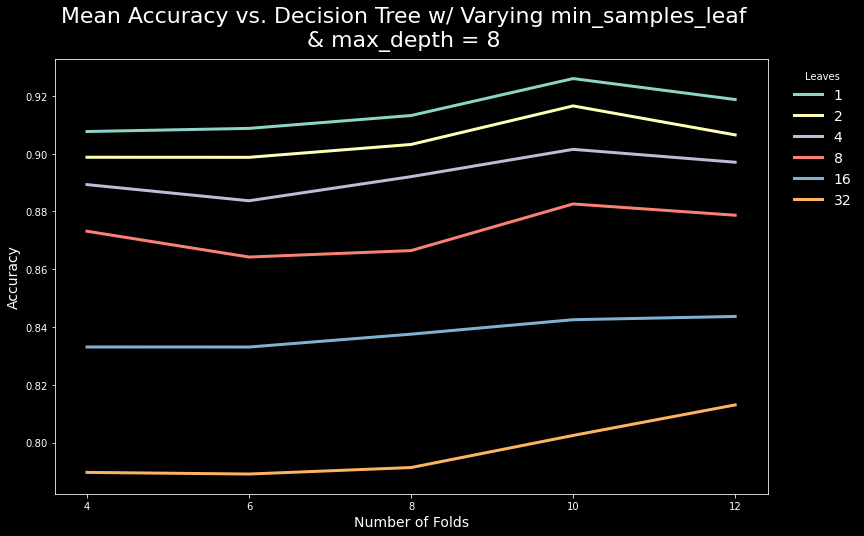

In [25]:
title = 'Decision Tree w/ Varying min_samples_leaf\n& max_depth = 8'
legend = 'Leaves'
DT_l_results = plot_tree_model('dt', title, legend)

In [26]:
#show comparison
DT_L_results = get_acc(DT_l_results, values, 'Leaves-DT')
model_results.append(DT_L_results)
model_names.append('DT-L')
DT_L_results.head(5)

,4-fold Acc.,10-fold Acc.
Leaves-DT,,
1,0.907657,0.925987
2,0.898748,0.916521
4,0.889282,0.901487
8,0.873138,0.882582
16,0.833069,0.842508


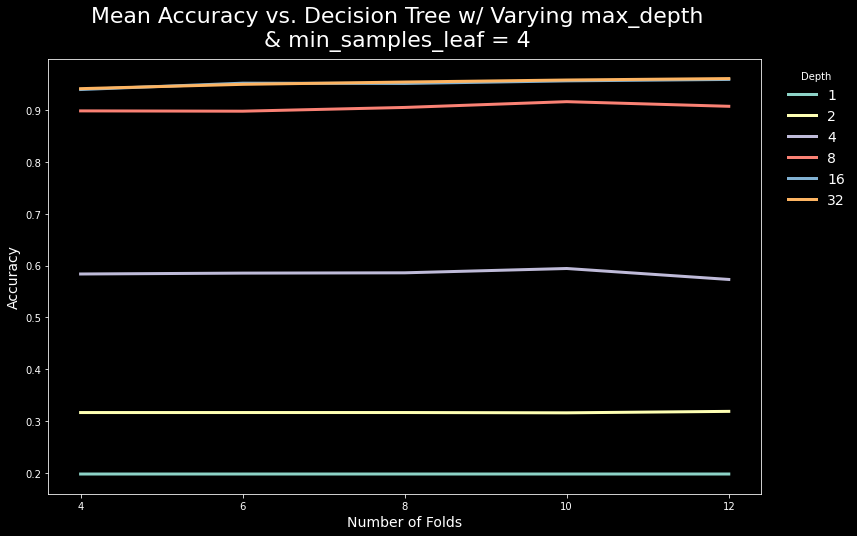

In [27]:
title = 'Decision Tree w/ Varying max_depth\n& min_samples_leaf = 4'
legend = 'Depth'
DT_d_results = plot_tree_model('dt', title, legend, 'depth')

In [28]:
#show comparison
DT_D_results = get_acc(DT_d_results, values, 'Depth-DT')
model_results.append(DT_D_results)
model_names.append('DT-D')
DT_D_results.head(5)

,4-fold Acc.,10-fold Acc.
Depth-DT,,
32,0.941049,0.957719
16,0.939383,0.956046
8,0.898192,0.915965
4,0.583753,0.594342
2,0.316634,0.316105


## Exploring Other Models - Random Forest Classifier

Let's try the same process with the Random Forest Classifier.

Some **advantages** of using a Random Forest:
* Better at reducing overfitting of data compared to other models.
* Flexible with both classification and regression problems.
* Can automatically handle missing values.
* Can handle both continuous and categorical variables.
* Don't need to normalize the data since it uses a rule-based approach.

Soem **disadvantages** of using a Random Forest:
* More computationally expensive compared to regular Decision Trees.
* Requires more time for training since it combines many decision trees.
* Harder and more complex to interpret.

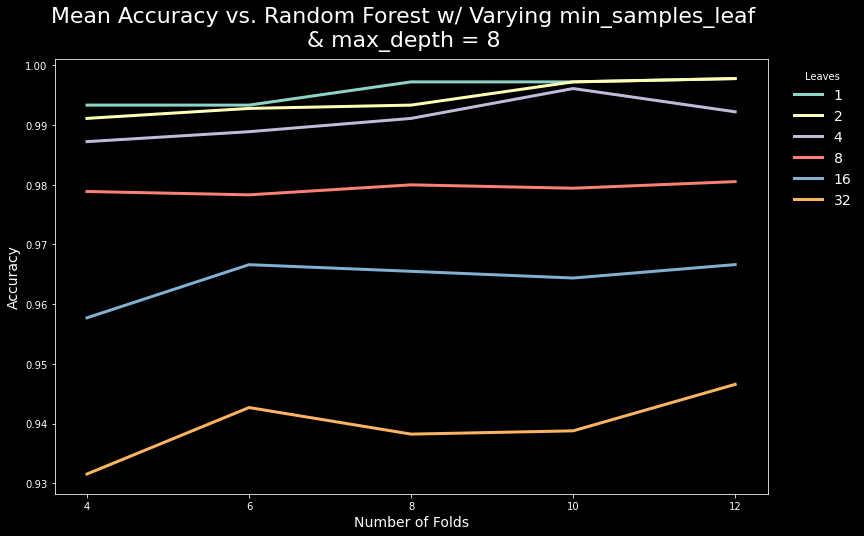

In [29]:
title = 'Random Forest w/ Varying min_samples_leaf\n& max_depth = 8'
legend = 'Leaves'
RF_l_results = plot_tree_model('rf', title, legend)

In [30]:
#show comparison
RF_L_results = get_acc(RF_l_results, values, 'Leaves-RF')
model_results.append(RF_L_results)
model_names.append('RF-L')
RF_L_results.head(5)

,4-fold Acc.,10-fold Acc.
Leaves-RF,,
2,0.991106,0.997222
1,0.993332,0.997219
4,0.987212,0.996105
8,0.978865,0.979410
16,0.957712,0.964373


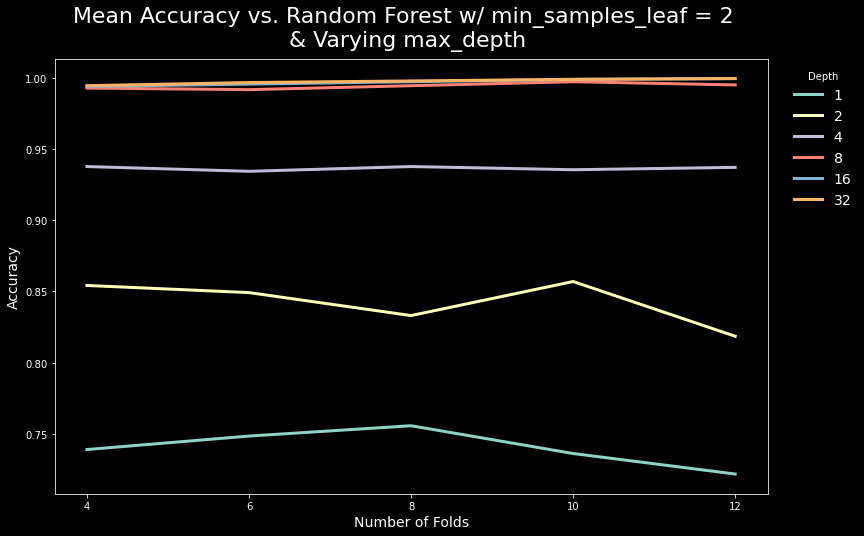

In [31]:
title = 'Random Forest w/ min_samples_leaf = 2\n & Varying max_depth'
legend = 'Depth'
RF_d_results = plot_tree_model('rf', title, legend, 'depth')

In [32]:
#show comparison
RF_D_results = get_acc(RF_d_results, values, 'Depth-RF')
model_results.append(RF_D_results)
model_names.append('RF-D')
RF_D_results.head(5)

,4-fold Acc.,10-fold Acc.
Depth-RF,,
16,0.993889,0.998889
32,0.994444,0.998889
8,0.992775,0.997222
4,0.937679,0.935441
2,0.854198,0.856962


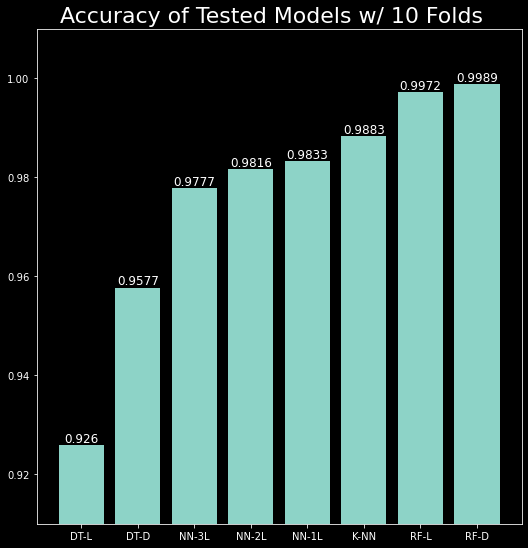

In [33]:
comp_acc(model_results, model_names)

## Visualizing the MLP Weights In A Neural Network

Sometimes looking at the learned coefficients of a neural network can provide insight into the learning behavior. For example if weights look unstructured, maybe some were not used at all, or if very large coefficients exist, maybe regularization was too low or the learning rate too high. ([scikit-learn.org](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html))

The input data consists of 8x8 pixel handwritten digits, leading to 64 features in the dataset. Therefore the first layer weight matrix has the shape (64, hidden_layer_sizes[0]). We can therefore visualize a single column of the weight matrix as a 8x8 pixel image.

In [34]:
def visualize_weights(coefs, layer, first=False, last=False):
    #get correct figsize
    coef_size = len(coefs[layer])    
#     print(f'coef_size: {coef_size}, sqrt: {np.sqrt(coef_size)}')

    # input layer
    if first:
        row = int(np.sqrt(coef_size))
        col = int(np.sqrt(coef_size))
        title = f'Input Layer Weights: ({coef_size}, {len(coefs[layer+1])})'
        fig_size = (row, col)
    #output layer
    elif last:
        row = 1
        col = 10
        title = f'Output Layer Weights: ({len(coefs[layer])}, 10)'
        fig_size = (16, 2) #play with numbers 
    #hidden layers
    else: 
        row = int(np.sqrt(coef_size))
        col = int(np.sqrt(coef_size))
        title = f'Layer: {layer} Weights: ({coef_size}, {len(coefs[layer+1])})'
        fig_size = (row, col)
    
    #figure details
    fig, axes = plt.subplots(row, col, figsize=fig_size)
    fig.suptitle(y=0.9, t=title, fontsize=22, va='bottom')
    
    #use global min & max to ensure all weights are shown on same scale
    vmin, vmax = coefs[layer].min(), coefs[layer].max()
    
    #plot details
    for coef, ax in zip(coefs[layer].T, axes.ravel()):
        if layer == 0:
            ax.matshow(coef.reshape(8, 8), cmap=plt.cm.gray, vmin=0.5 * vmin, vmax=0.5 * vmax)
        else:
            ax.matshow(coef.reshape(16, 16), cmap=plt.cm.gray, vmin=0.5 * vmin, vmax=0.5 * vmax)
        ax.set_xticks(())
        ax.set_yticks(())
    
    plt.show()

In [35]:
def cross_validate_nn_visualize(neurons, n_splits=4, layers=1, activator='logistic'):
    train_acc = []
    test_acc = []
    coefs = []
    kf = KFold(n_splits, shuffle=True, random_state=1)
    for train_index, test_index in kf.split(data):
        #splitting the data
        train_features, test_features = data.loc[train_index], data.loc[test_index]
        train_labels, test_labels = labels.loc[train_index], labels.loc[test_index]
        
        #hide warnings, then train model
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=ConvergenceWarning) 
            model = train_nn(train_features, train_labels, neurons, layers, activator)
            coefs.append(model.coefs_)
            
        #calculate accuracies
        train_accuracy = test(model, train_features, train_labels)
        test_accuracy = test(model, test_features, test_labels)
        
        #append accuracies to list
        train_acc.append(train_accuracy)
        test_acc.append(test_accuracy)
        
    #pass coefs and layer to visualization function
    print(f'Weight Coefficients: {[coef.shape for coef in model.coefs_]}')    
    for layer in range(layers+1):
        if layer == 0: #input layer
            visualize_weights(coefs[layer], layer, True, False)
        elif layer == layers: #output layer
            visualize_weights(coefs[layer], layer, False, True)
        else: #hidden layers
            visualize_weights(coefs[layer], layer)
        
    return np.mean(train_acc), np.mean(test_acc)

Weight Coefficients: [(64, 256), (256, 256), (256, 10)]


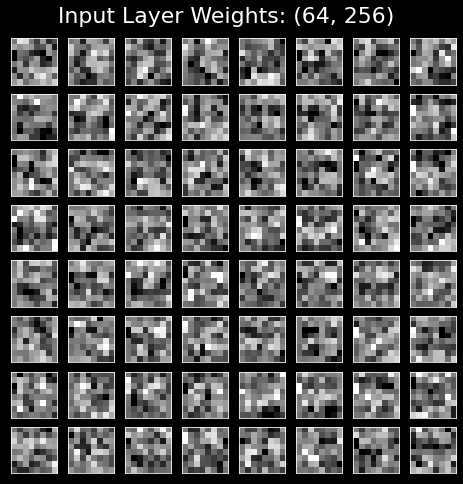

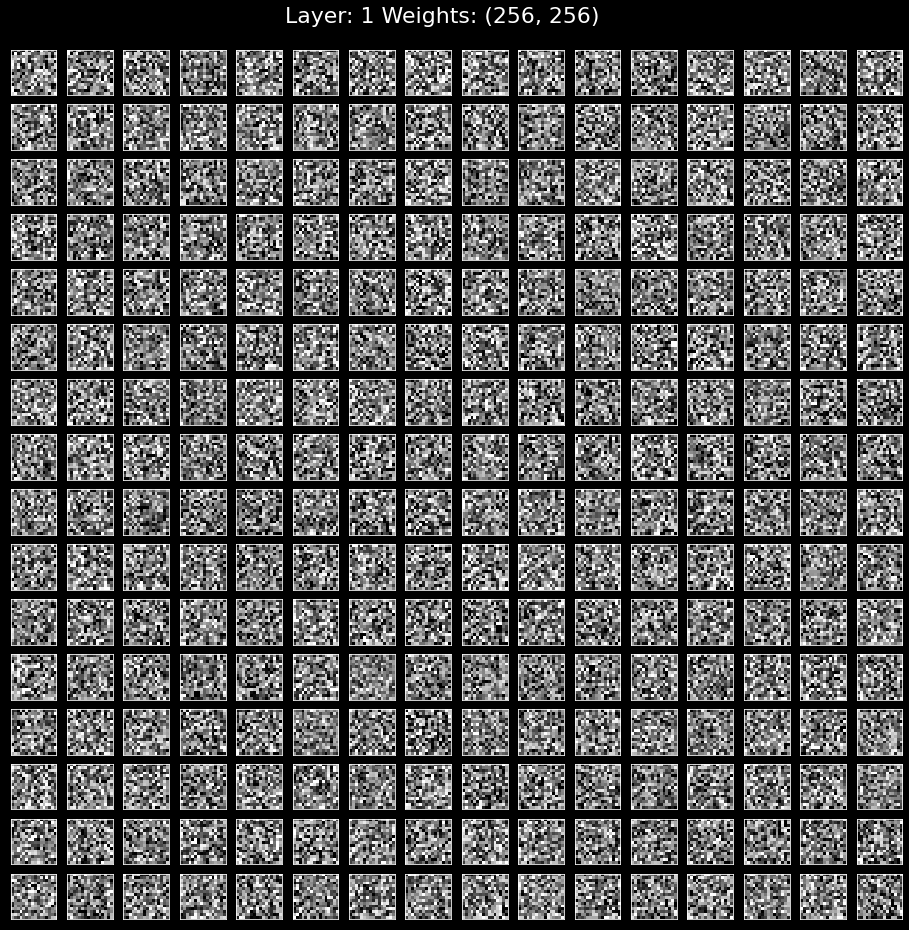

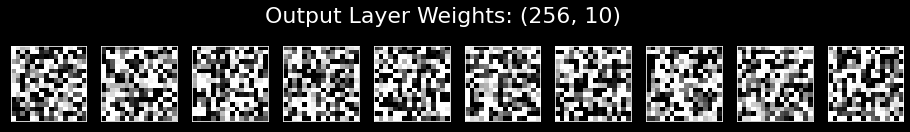

Training Accuracy: 1.0
Testing Accuracy: 0.9810738671632526


In [36]:
train_acc_v, test_acc_v = cross_validate_nn_visualize(neurons=256, n_splits=10, layers=2)
print(f'Training Accuracy: {train_acc_v}')
print(f'Testing Accuracy: {test_acc_v}')

# Conclusion

In this project, we have tested numerous machine learning models and algorithms in the hopes of creating a handwritten digit classifier. While our visualization of the image was unsuccessful (we can't detect any digits in the produced images), we were able to explore, examine, and identify patterns of performance amongst our models.

In the end, our **Random Forest** model with `max_depth = 16` / `max_depth = 32` values performed the best with an accuracy of ~99.89%+. However, it should be noted that virtually every model we tested suffered from overfitting. Increasing the number of folds during cross-validation did help alleviate the issue a little bit, but not enough to remove the problem.

Our **Neural Networks** all performed similarly, with accuracies ranging from **~97.7 - 98.2%** accuracy. The **Decision Tree** models performed the worst of the bunch, with accuracies from **~92.7 - 95.9%**.

## Our Goals
* **To explore why image classification is difficult**:
    * The sheer amount of features in a single image can make processing a very long and computationally expensive process.
    * The resolution of images varies, and has a big impact on the accuracy of models.
    * There won't always be discernible patterns in an image - The world is analog and constantly motion, so detecting patterns in everything is very difficult.

* **To observe the limitations of traditional machine learning models for image classification**:
    * All of our models were overfitting, making our results less reliable.
    * Tradeoff between available data and processing/computation cost.

* **To train, test, and improve a few different deep neural networks for image classification**:
    * Random Forest models tended to perform better than the single, double, and triple layered neural networks and decision trees.

# Further Steps

Some ideas to take this project further:

* Experiment with different activation functions in our neural networks.
* Tweak the parameters for all of our models more, and using multiple combinations of them (Hyperparameter Tuning).
* Do more research into how to visualize the coefficient weights.